## Figure 1(g): 
## Salish Sea map with salinity and oil transfers by region

Use `analysis-rachael/env/monte_carlo.yaml` to create an environment for this notebook:
```
 conda env create -f [analysis-rachael/env/monte_carlo.yaml]
```
or, to activate this environment, use
```
 conda activate monte-carlo
```
To deactivate an active environment, use
```
 conda deactivate
```

This notebook relies on functions in `monte_carlo_utils.py` and requires the inclusion of the directory with this script, namely `../../../scripts`, in PYTHONPATH, e.g.:
```
export PYTHONPATH=$PYTHONPATH:/path/to/analysis-rachael/scripts
```
or uncommenting the following lines to import the scripts directory using sys: 
```
import sys
sys.path.insert(0, '../../../scripts')
```

In [1]:
import cartopy.crs
from cartopy import feature
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmocean.cm
import numpy
import xarray
import pandas
import pathlib
import yaml

# predefined naming conventions
import MEOPAR2022_setup as oil

# load my function(s)
# import sys
#sys.path.insert(0, '../../../scripts')
from monte_carlo_utils import get_DOE_df,get_DOE_oilclassification

# graphics style
#plt.style.use('seaborn-poster')
plt.style.use(r"./meopar2022_matplotlibrc.template")

gallons_to_liters = 3.78541

## Organize oil transfers by regions

In [2]:
# User inputs
yaml_input = pathlib.Path('/data/MIDOSS/marine_transport_data/')
yaml_output = pathlib.Path('/ocean/rmueller/MIDOSS/tmp_output')
graphics_directory = pathlib.Path('/ocean/rmueller/MIDOSS/graphics/MEOPAR_ASM_2022')

# open oil_attribution.yaml for paths
oil_attribution_file = yaml_input / 'oil_attribution.yaml'
with open(oil_attribution_file) as file:
    oil_attrs = yaml.load(file, Loader=yaml.Loader) 

In [3]:
# define latitude bins
lat_partition = [46.9, 48.3, 48.7]
# regional tags
regions = ['Columbia River','Puget Sound','Anacortes','Whatcom County']

In [4]:
DOEdf=get_DOE_df(
    oil_attrs['files']['doe_transfers'], 
    oil_attrs['files']['oil_facilities'], 
    group='no'
)
oil_classification = get_DOE_oilclassification(
    oil_attrs['files']['doe_transfers']
)
type_description = ['TANK BARGE','TUGBOAT','TANK SHIP']
facility_names = oil_attrs['categories']['US_origin_destination']
exports_byOil={}
imports_byOil={}
for oil_type in oil.types: 
    exports_byOil[oil_type] = DOEdf.loc[
        (DOEdf.TransferType == 'Cargo') &
        (DOEdf.ReceiverTypeDescription.isin(type_description)) & 
        (DOEdf.Deliverer.isin(facility_names)) & 
        (DOEdf.Product.isin(oil_classification[oil_type])), 
        ['TransferQtyInGallon', 'ExportRegion']
    ].groupby('ExportRegion').sum()
    imports_byOil[oil_type] = DOEdf.loc[
        (DOEdf.TransferType == 'Cargo') &
        (DOEdf.DelivererTypeDescription.isin(type_description)) & 
        (DOEdf.Receiver.isin(facility_names)) & 
        (DOEdf.Product.isin(oil_classification[oil_type])), 
        ['TransferQtyInGallon', 'ImportRegion']
    ].groupby('ImportRegion').sum()

In [5]:
exports_byRegion = {}
imports_byRegion = {}
combined_byRegion = {}
for region in regions:
    exports_byRegion[region]={}
    imports_byRegion[region]={}
    combined_byRegion[region]={}
    my_list_in = []
    my_list_out = []
    for oil_type in oil.types:
        try:
            my_list_in.append(imports_byOil[oil_type]['TransferQtyInGallon'].loc[region])
            my_list_out.append(exports_byOil[oil_type]['TransferQtyInGallon'].loc[region])
        except:
            my_list_in.append(0)
            my_list_out.append(0)
    my_array_in = numpy.asarray(my_list_in)
    my_array_out = numpy.asarray(my_list_out)
    imports_byRegion[region] = pandas.DataFrame (my_array_in, columns = ['Volume'], index = oil.types)
    exports_byRegion[region] = pandas.DataFrame (my_array_out, columns = ['Volume'], index = oil.types)
    
    combined_byRegion[region]=imports_byRegion[region]+exports_byRegion[region]
    #combined_byRegion[region]=combined_byRegion[region]*gallons_to_liters

## Create map of salinty to use for region orientation

In [6]:
georef = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02")
mesh_mask = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02")
water_mask = mesh_mask.tmaskutil.isel(time=0)
fields = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV19-05")
salinity = fields.salinity.sel(time="2020-08-14 14:30", depth=0, method="nearest").where(water_mask)

In [7]:
vessel_types = [
    'tanker', 
    'atb', 
    'barge'
]
oil_types = [
    'akns', 
    'bunker', 
    'dilbit', 
    'jet', 
    'diesel', 
    'gas', 
    'other'
]
oil_colors = oil.colors7

### Plot by facility groups

In [8]:
lat={}
lat['whatcom'] = 48.88
lat['anacortes']=48.2
lat['puget']=47.5
lon=-122.758

/home/rmueller/miniconda3/envs/monte-carlo/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/tmp/ipykernel_10782/2507504989.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


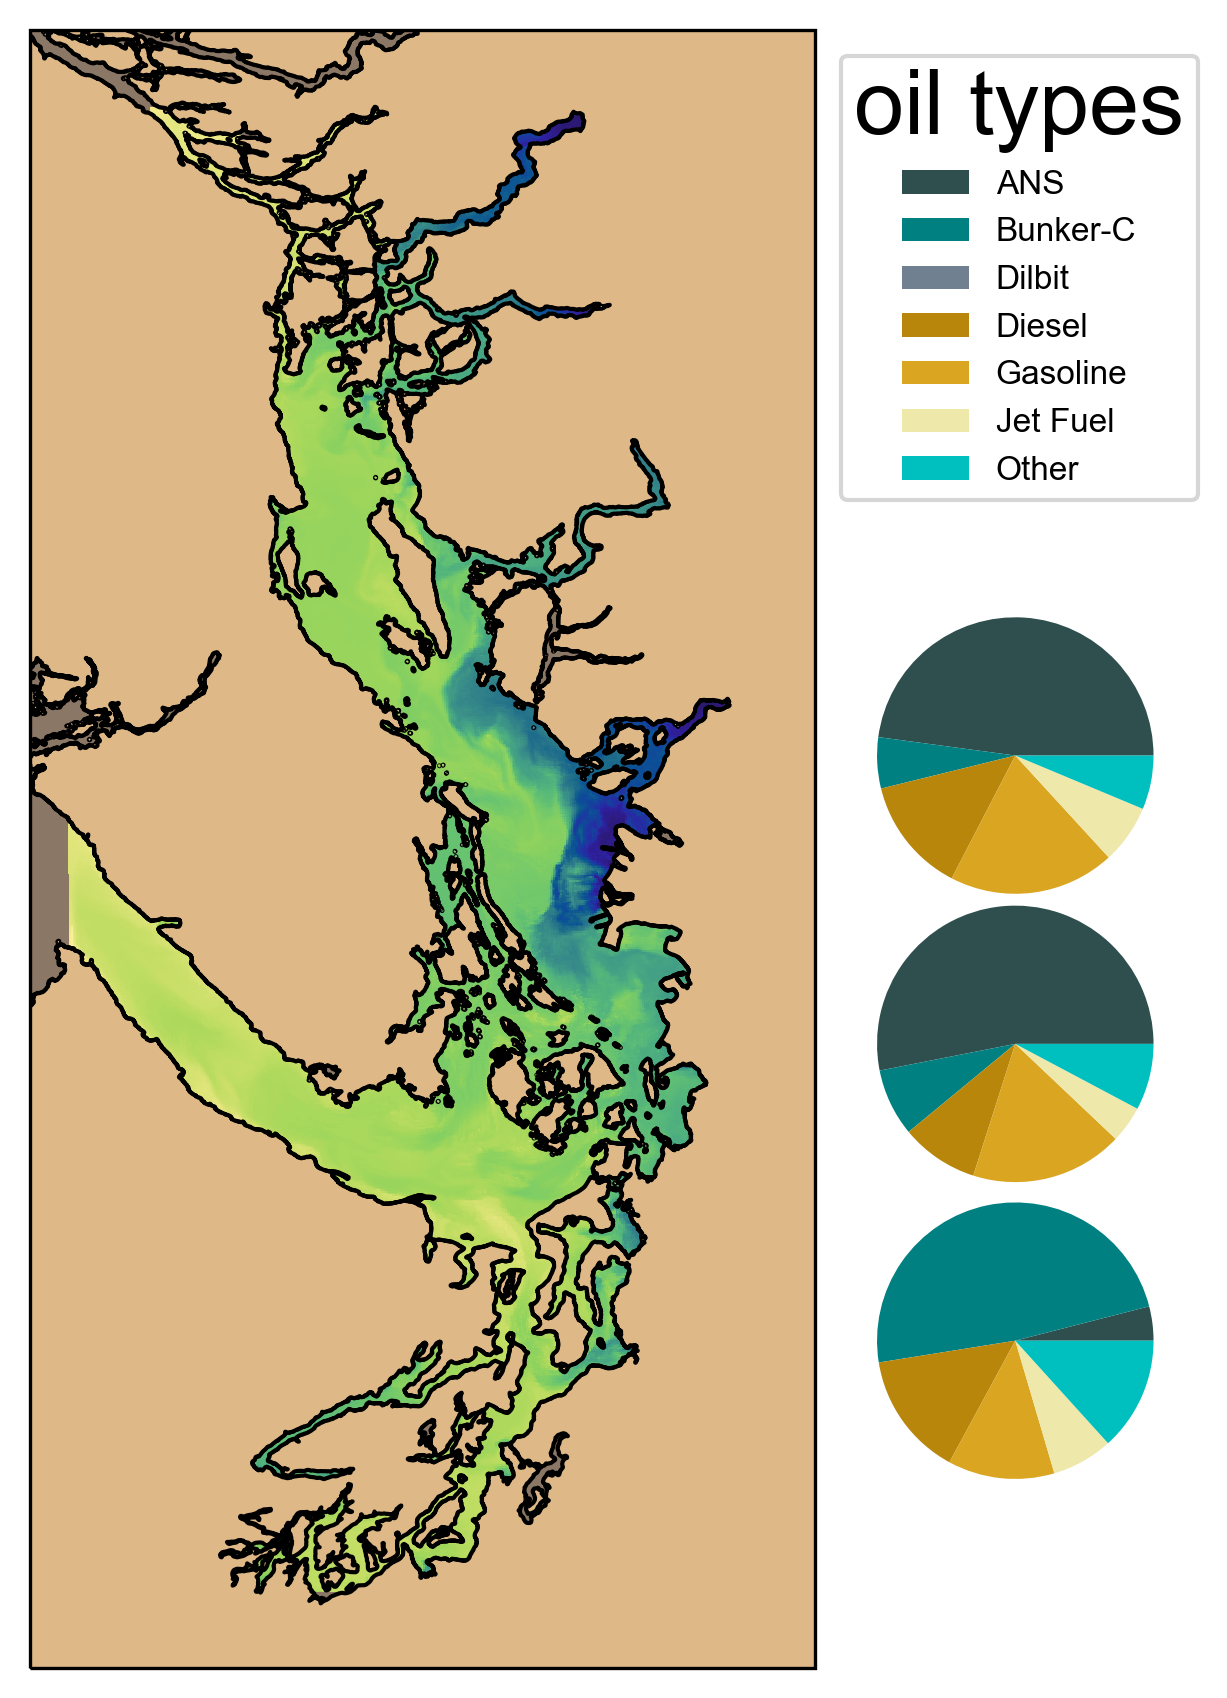

In [9]:
# the offsets needed for indexing from lower left of graphic boundary
x0 = -0.10
y0 = -0.044

# mapping specifications
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

fig,ax = plt.subplots(
    1, 1, figsize=(12, 6), subplot_kw={"projection": rotated_crs, "facecolor": "#8b7765"}
)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood'))
quad_mesh = ax.pcolormesh(
    georef.longitude, georef.latitude, salinity, transform=plain_crs, cmap=cmocean.cm.haline, shading="auto"
)

# calculate location of marine terminal within graphic window
scale = 1.2
#~~~~~~~~~~~~~~~~ Whatcom ~~~~~~~~~~~~~~~~~~
xleft = ((lon - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((lat['whatcom'] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_whatcom = fig.add_axes([xleft+x0, ybottom+y0,.08*scale, .2*scale])
ax_whatcom.pie(combined_byRegion['Whatcom County']['Volume'], colors = oil.colors7)

#~~~~~~~~~~~~~~~~ Puget ~~~~~~~~~~~~~~~~~~
xleft = ((lon - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((lat['puget'] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_puget = fig.add_axes([xleft+x0, ybottom+y0,.08*scale, .2*scale])
ax_puget.pie(combined_byRegion['Puget Sound']['Volume'], colors = oil.colors7)

#~~~~~~~~~~~~~~~~ ANACORTES ~~~~~~~~~~~~~~~~~~
xleft = ((lon - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((lat['anacortes'] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_anacortes = fig.add_axes([xleft+x0, ybottom+y0,.08*scale, .2*scale])
ax_anacortes.pie(combined_byRegion['Anacortes']['Volume'], colors = oil.colors7)

fig.legend(
    bbox_to_anchor=(.72, .95),
    title='oil types',
    prop={'size': 8},
    labels = oil.labels
)
#ax_north.bar(oil_types, 1e1* numpy.ones(7), width = 1)
fig.canvas.draw()
fig.tight_layout()

plt.savefig(graphics_directory/'Figure_1g_MEOPAR_ASM_2022.png')
plt.show()

###### 